In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0, '../')
import pandas as pd
import tqdm
import pickle

import vis
import numpy as np
import warnings

모델 및 데이터 로드 단계
Feather 파일로 저장한 이벤트/게임/선수 데이터를 읽어온다.
- Pickle로 저장해 둔 학습된 soccermix 모델(cat_model, loc_models, dir_models)을 복원한다.
- 학습 시 계산한 이벤트별 확률 가중치(cat_weights → loc_weights → dir_weights)도 함께 로드한다.
- team_id, game_id 정보를 이벤트 행과 연결해 이후 시각화 및 분석에 활용할 수 있도록 병합한다.
- models.pkl 구조는 순서(cat_model → loc_models → dir_models)대로 로드해야 함

In [2]:
### Configure file and folder names
data_feather = "../data/soccermix_J1_all_data.feather"

models = "../data/soccermix_J1_models.pkl"
c_weights = "../data/soccermix_J1_all_catweights.pkl"
l_weights = "../data/soccermix_J1_all_locweights.pkl"
d_weights = "../data/soccermix_J1_all_dirweights.pkl"


In [3]:
def loadall(filename):
    with open(filename, "rb") as f:
        while True:
            try:
                yield pickle.load(f)
            except EOFError:
                break
            
items = loadall(models)
d_w = loadall(d_weights)

In [4]:
cat_model = next(items)
loc_models = next(items)
dir_models = next(items)
dir_weights = next(d_w)

In [5]:
X = pd.read_feather(data_feather)
games = pd.read_feather('../data/JL_games.feather')
japan_id_map = dict(zip(games["home_team_name"], games["home_team_id"]))
merged_weights = dir_weights.copy()
merged_weights["team_id"] = X.team_id.values
merged_weights["game_id"] = X.game_id.values

In [6]:
compare = {1886, 1889} # 비셀 고베, 산프레체 히로시마 - 2024 J리그 1위팀, 2위팀
vectors = {}
set_teams = set(merged_weights.team_id.astype('int'))

for p in compare:
    other = compare - {p}
    p2 = next(iter(other))
    
    # p(team)의 홈 경기 vs p2(team)
    A_home_B = games[( (games.home_team_id == p) & (games.away_team_id == p2))].game_id.values

    # p(team)의 원정 경기 vs p2(team)
    A_away_B = games[( (games.away_team_id == p) & (games.home_team_id == p2))].game_id.values

    A_other = games[(((games.home_team_id == p) & ~(games.away_team_id == p2))
                         | ((games.away_team_id == p) & ~(games.home_team_id == p2))
                        )].game_id.values
    # 홈에서 라이벌과 경기 시 방향 확률 합
    vec1 = merged_weights.loc[((merged_weights.game_id.isin(A_home_B)) 
                                  & (merged_weights.team_id == p)), dir_weights.columns].sum().values
    # 라이벌 외의 팀과 경기 시 방향 확률 합
    vec2 = merged_weights.loc[((merged_weights.game_id.isin(A_other))
                                  & (merged_weights.team_id == p)), dir_weights.columns].sum().values
    
    vec2 /= 38
    # 원정에서 라이벌과 경기 시 방향 확률 합
    vec3 = merged_weights.loc[((merged_weights.game_id.isin(A_away_B)) 
                                  & (merged_weights.team_id == p)), dir_weights.columns].sum().values
    
    vectors[f'{int(p)}_{int(p2)}_0'] = vec1 #home game of team 1 against team 2
    vectors[f'{int(p)}_{int(p2)}_1'] = vec2 #all games of team 1 not against team 2
    vectors[f'{int(p)}_{int(p2)}_2'] = vec3 #away game of team 1 against team 2
vectors_pd = pd.concat({k: pd.DataFrame(v).T for k,v in vectors.items()}).droplevel(level=1)
vectors_pd.index.name = "team_game"
vectors_pd.columns = dir_weights.columns


### How did Vissel Kobe play differently the away game against Sanfrece (win) vs home game against Sanfrecce (draw)

In [7]:
'''
인덱스 형태	의미
A_B_0	A가 홈, B를 상대로한 경기
A_B_1	A가 B 아닌 나머지 팀 상대로한 경기
A_B_2	A가 원정, B를 상대로한 경기
'''
vectors_pd

,throw_in_0_0,throw_in_1_0,throw_in_1_1,pass_0_0,pass_0_1,pass_0_2,pass_0_3,pass_1_0,pass_2_0,pass_2_1,...,dribble_4_0,dribble_4_1,dribble_4_2,dribble_5_0,dribble_5_1,dribble_6_0,interception_0_0,interception_1_0,foul_0_0,shot_penalty_0_0
team_game,,,,,,,,,,,,,,,,,,,,,
1889_1886_0,4.000000,8.811665,11.188335,22.265380,0.794589,36.159158,2.029213,47.310850,39.987456,21.785788,...,34.662936,4.252825,32.838549,66.785033,11.222300,38.981949,4.005222,3.994778,9.000000,0.000000
1889_1886_1,10.105263,5.369933,7.051120,26.982857,0.620651,34.836910,2.132031,47.573301,40.761928,17.489737,...,35.639507,4.851107,33.102864,59.513083,12.407462,47.153017,5.445636,5.054363,13.631579,0.184211
1889_1886_2,14.000000,6.634777,7.365223,20.692654,0.375971,27.701721,1.344960,54.862332,41.295547,13.324717,...,31.213559,4.336457,29.875650,48.098264,7.968815,33.267711,4.005087,5.994913,19.000000,0.000000
1886_1889_0,8.000000,6.795132,5.204868,23.191389,0.229244,22.682953,1.259214,30.653011,41.551276,12.205669,...,33.741270,4.204876,31.170083,29.894672,6.427804,29.651837,8.495674,6.504326,14.000000,0.000000
1886_1889_1,11.526316,3.977309,7.364796,21.404393,0.369677,25.813937,2.001976,44.489657,38.115962,18.098927,...,33.165475,4.030362,30.616170,47.851489,10.759755,33.592524,6.114877,5.937754,10.736842,0.184211
1886_1889_2,10.000000,4.839937,2.160063,20.624666,0.393191,27.564060,2.154156,28.772377,55.169150,26.680172,...,49.554144,5.042298,44.778332,39.418768,9.952617,32.448417,8.956451,9.043549,14.000000,0.000000


throw_in 2
throw_in_0 1
throw_in_1 2


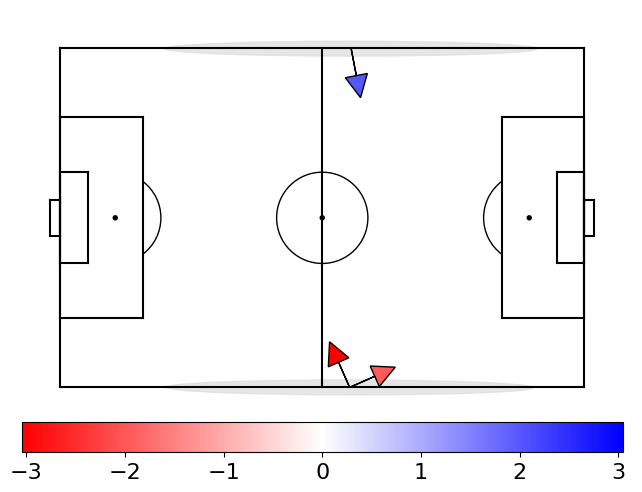

pass 7
pass_0 4
pass_1 1
pass_2 2
pass_3 2


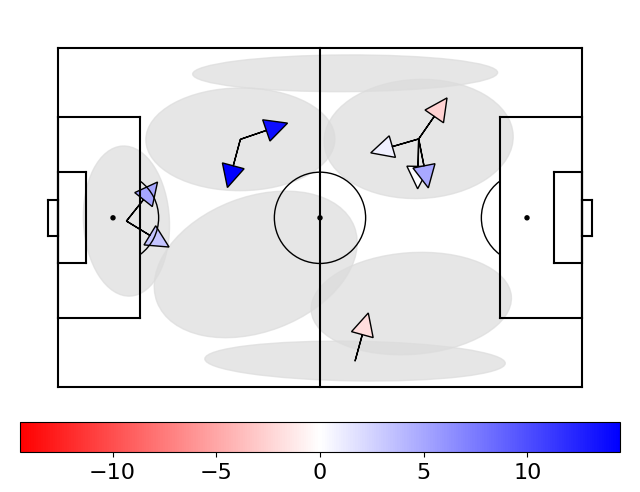

keeper_catch 6
keeper_catch_0 3
keeper_catch_1 2
keeper_catch_2 1
keeper_catch_3 1
keeper_catch_4 2


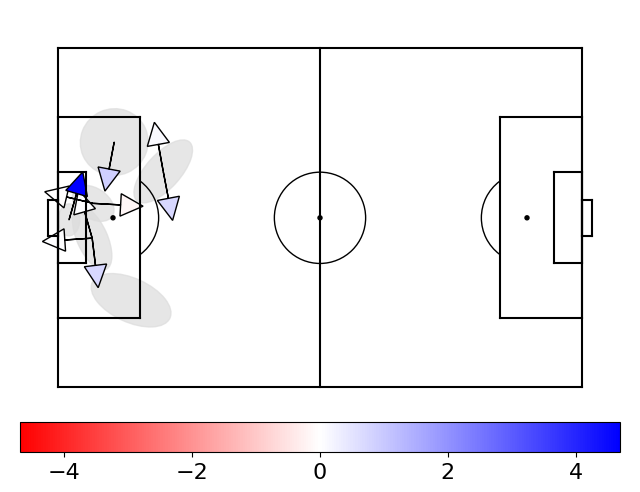

cross 2


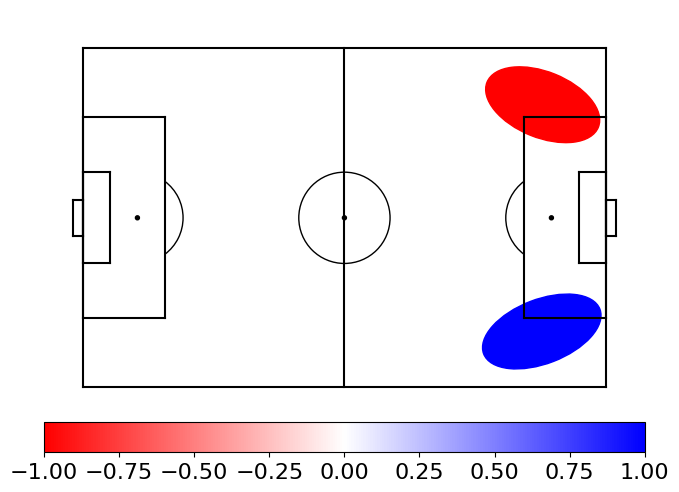

shot 1


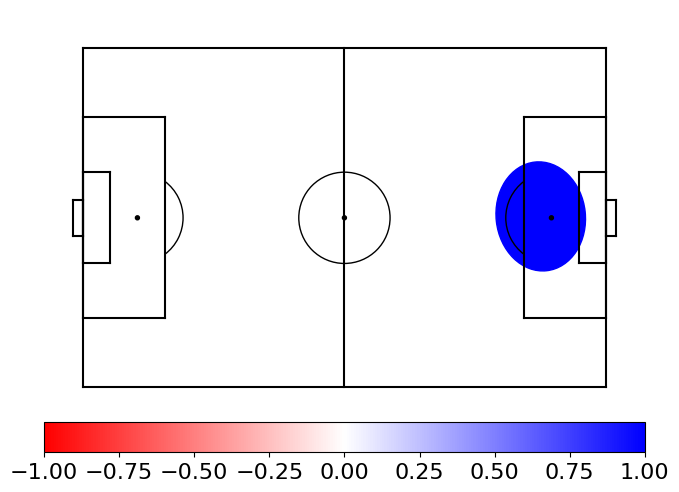

bad_touch 1


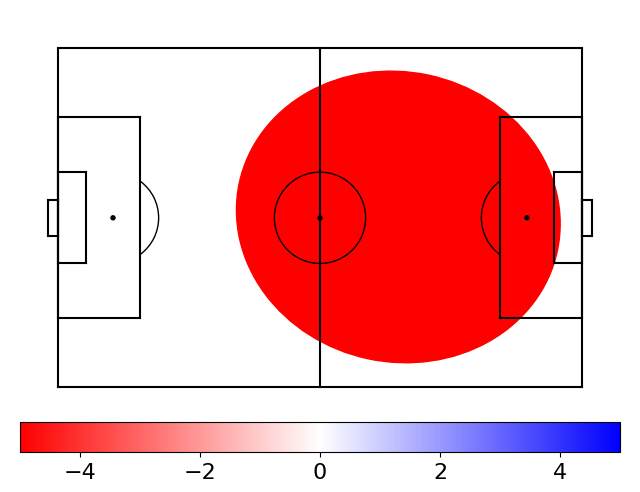

corner 2


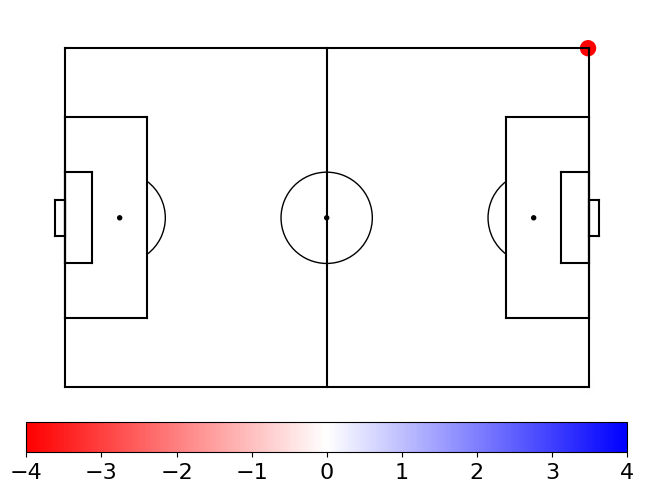

tackle 2


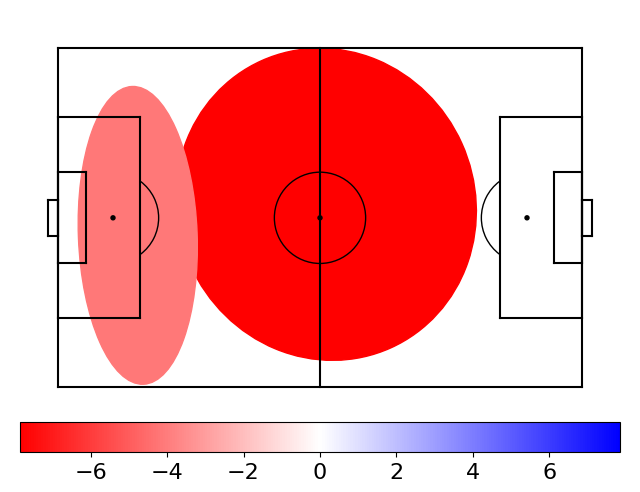

freekick 2


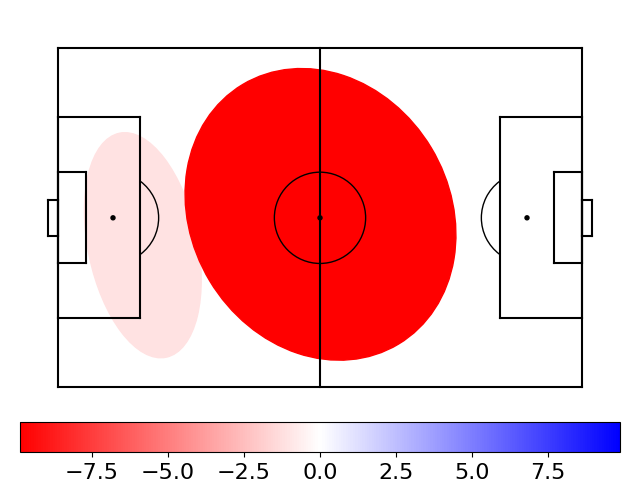

goalkick 1


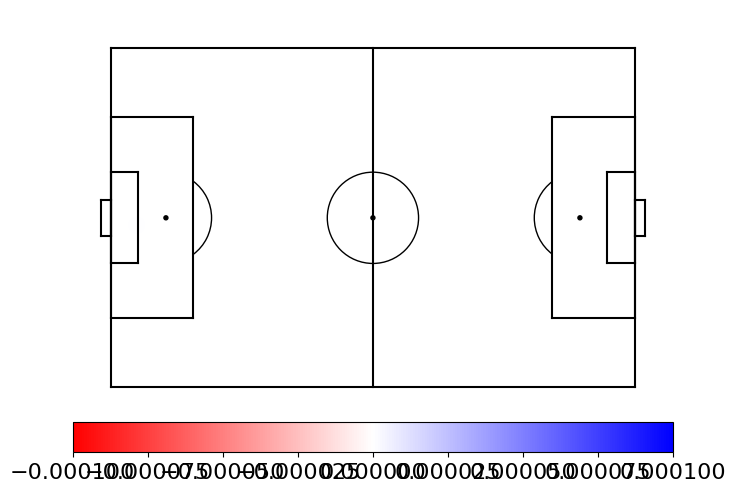

clearance 1


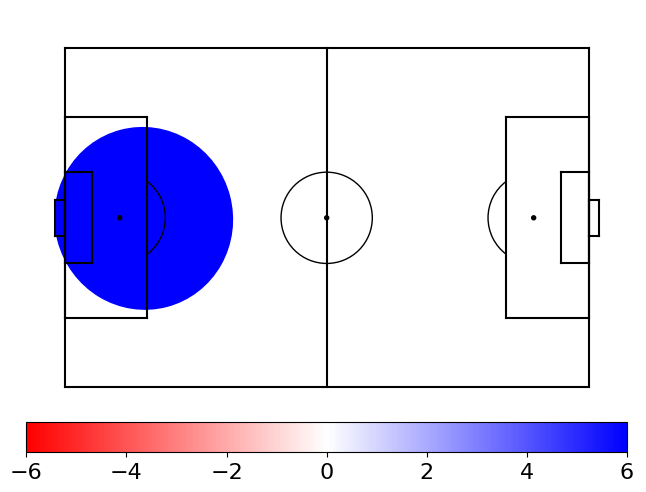

take_on 1


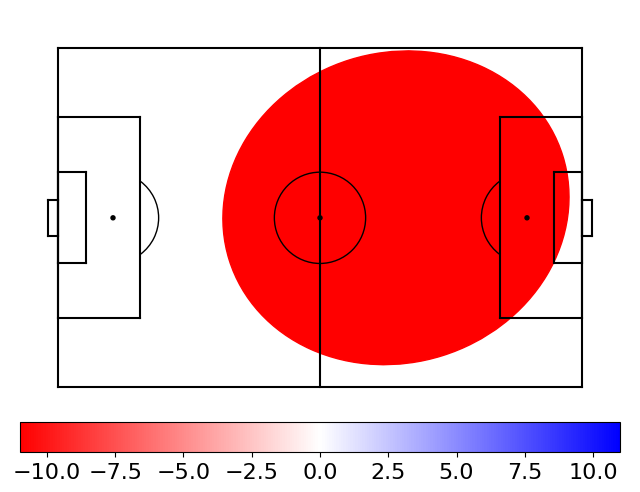

dribble 7
dribble_0 1
dribble_1 1
dribble_2 1
dribble_3 2
dribble_4 3
dribble_5 2
dribble_6 1


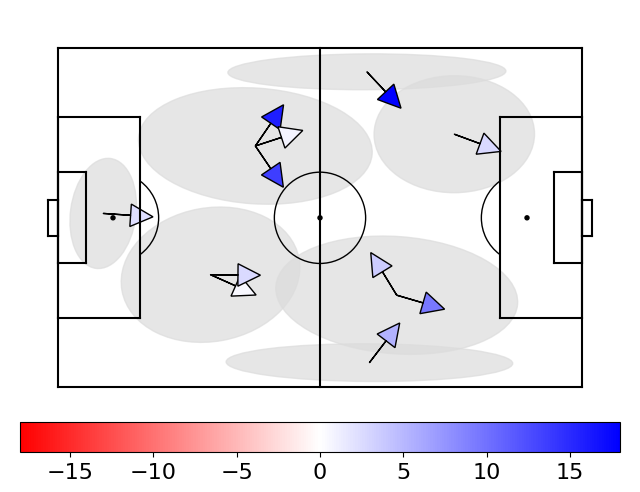

interception 2


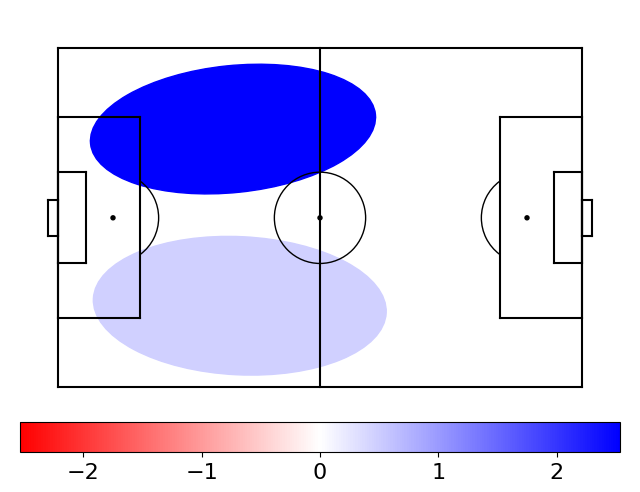

foul 1


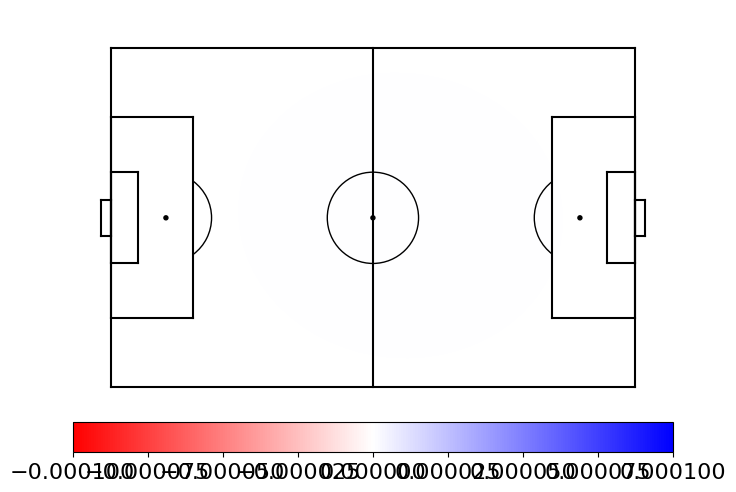

shot_penalty 1


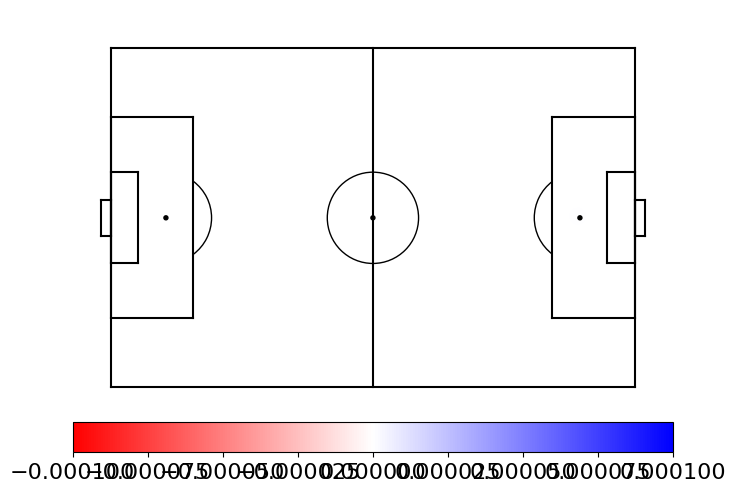

In [8]:
'''
비셀 고베 vs 산프레체 히로시마 
비셀 고베가 산프레체 히로시마를 상대할 때 홈과 원정에서 전술적으로 무엇이 달라지는가를 시각화
difference = vec_p1(원정) - vec_p2(홈)
파란색 = vec_p1에서 더 강조하는 전술 행동
'''
vis.show_component_differences(loc_models, dir_models, vectors_pd.loc['1886_1889_2'], vectors_pd.loc['1886_1889_0'], '비셀 고베', '산프레체 히로시마', save=False)


### How did Vissel Kobe play differently the away game against city (win) vs any other game?

throw_in 2
throw_in_0 1
throw_in_1 2


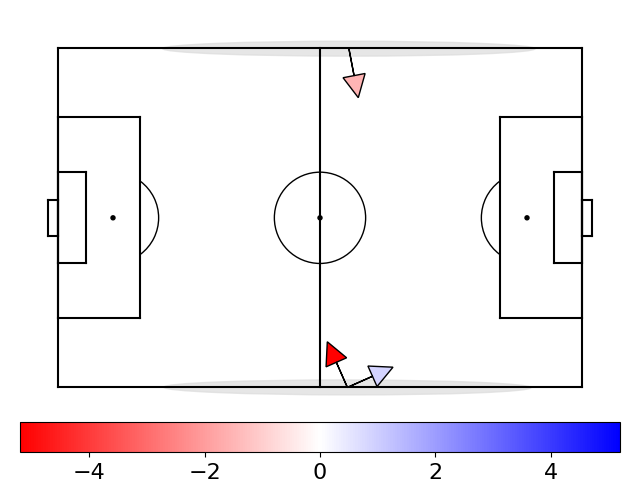

pass 7
pass_0 4
pass_1 1
pass_2 2
pass_3 2


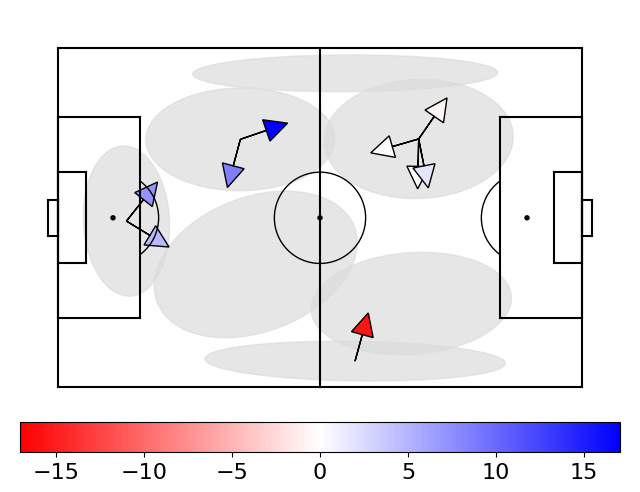

keeper_catch 6
keeper_catch_0 3
keeper_catch_1 2
keeper_catch_2 1
keeper_catch_3 1
keeper_catch_4 2


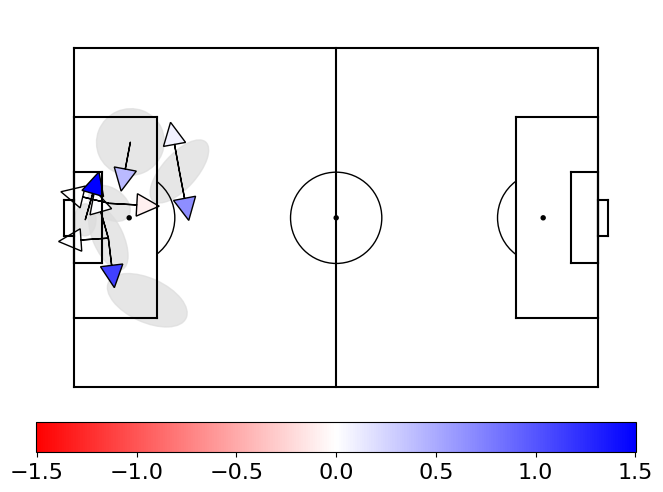

cross 2


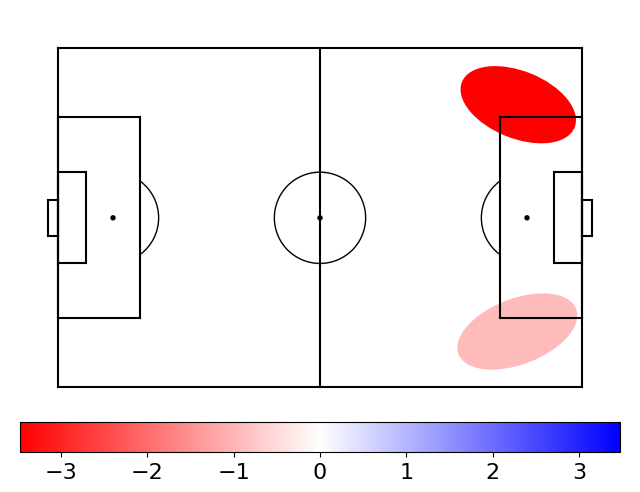

shot 1


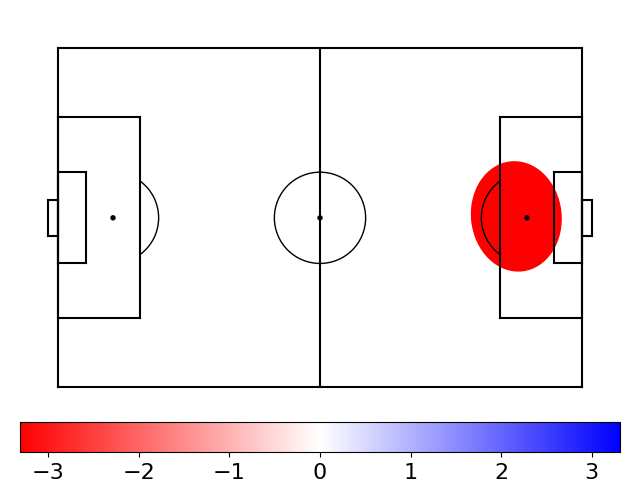

bad_touch 1


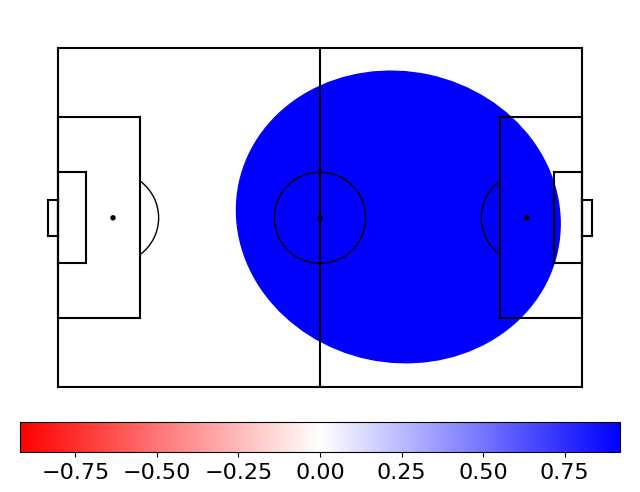

corner 2


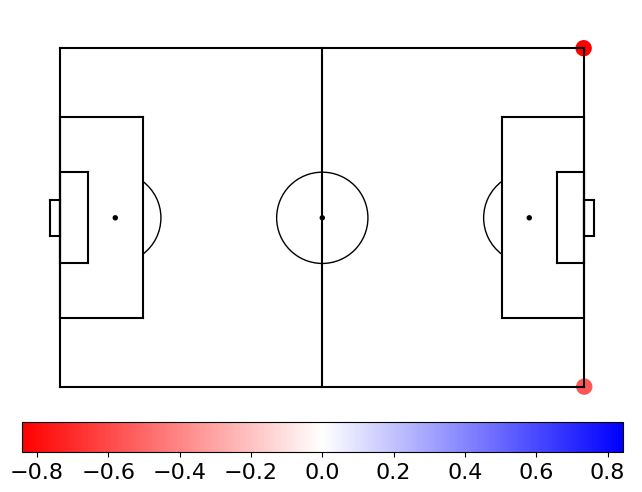

tackle 2


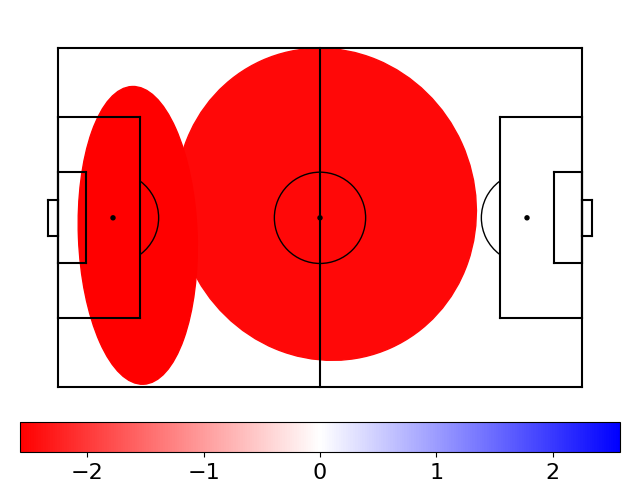

freekick 2


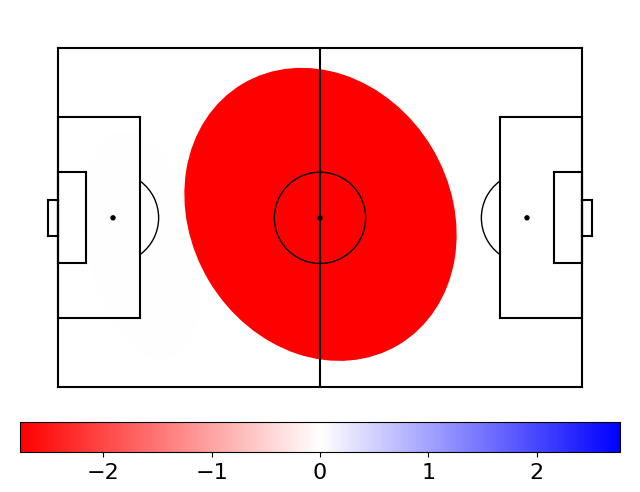

goalkick 1


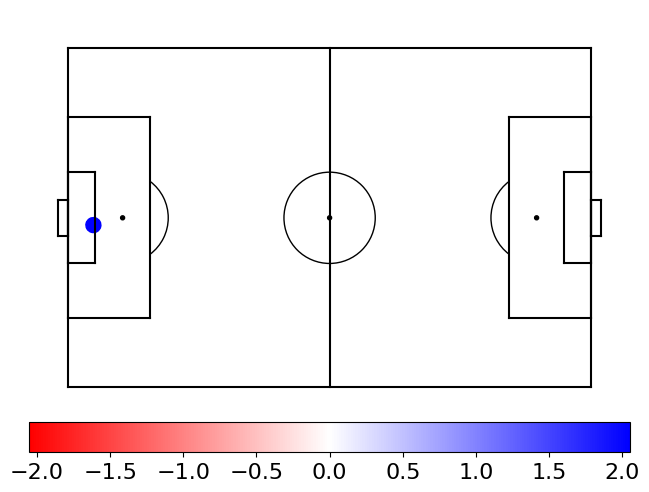

clearance 1


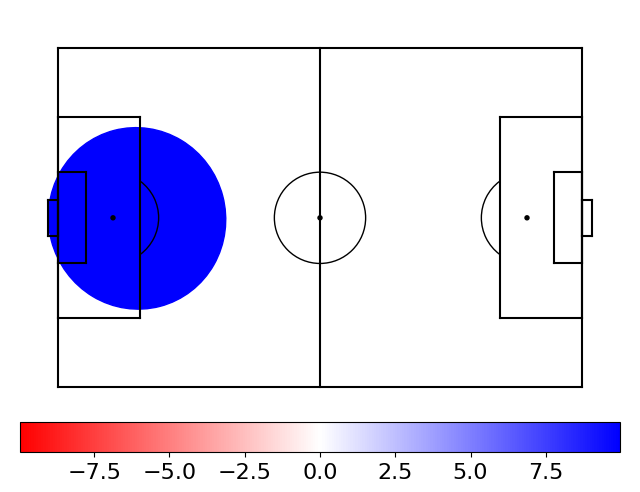

take_on 1


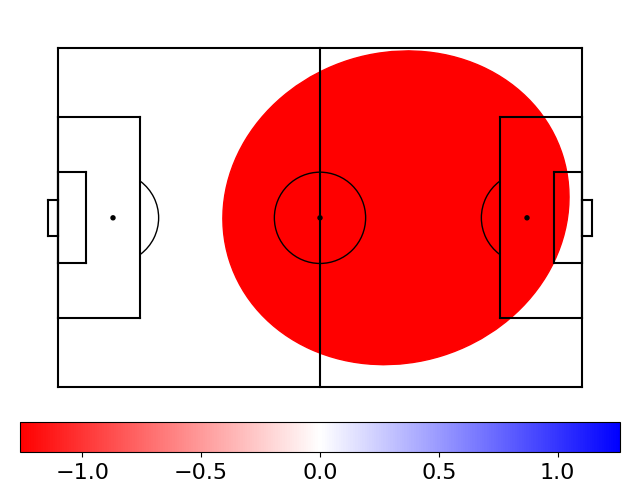

dribble 7
dribble_0 1
dribble_1 1
dribble_2 1
dribble_3 2
dribble_4 3
dribble_5 2
dribble_6 1


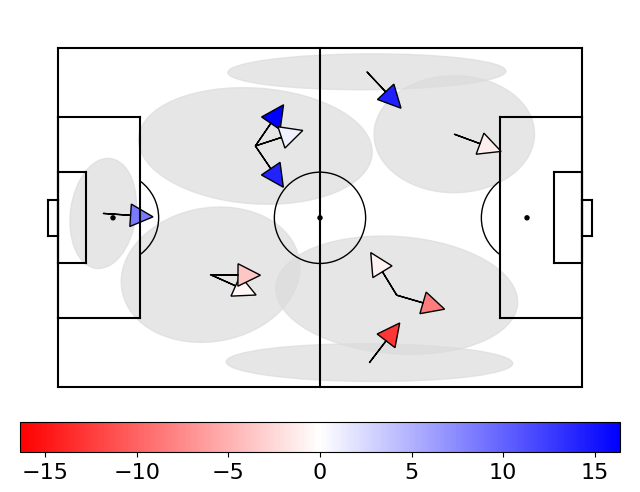

interception 2


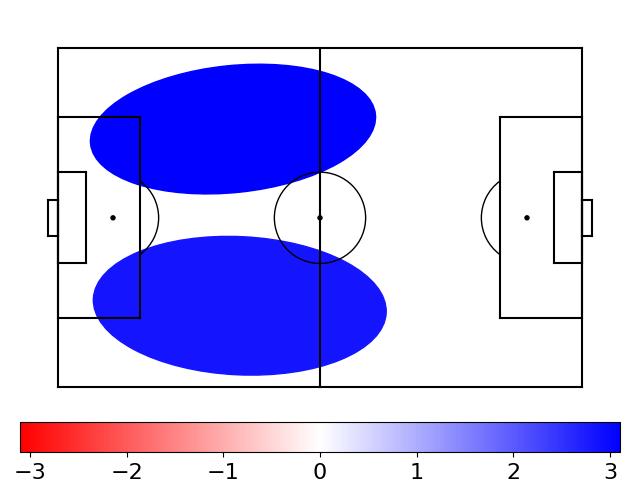

foul 1


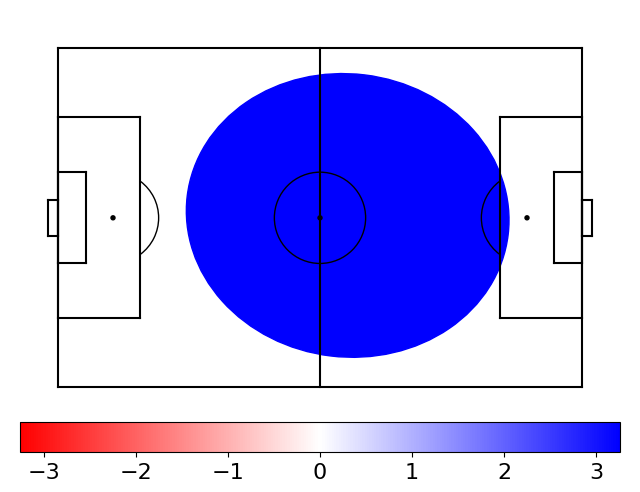

shot_penalty 1


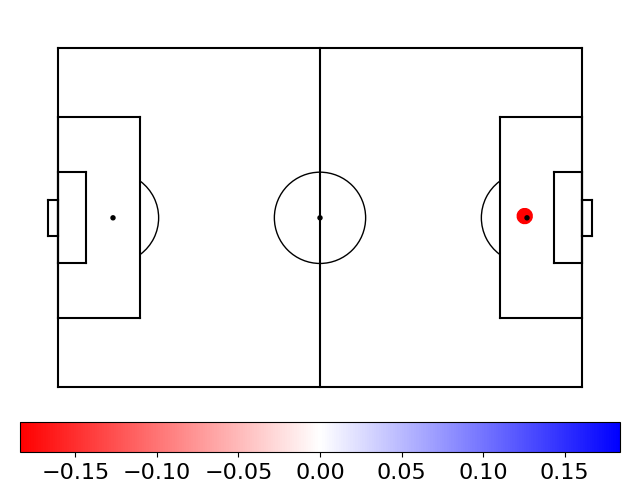

In [9]:
vis.show_component_differences(loc_models, dir_models, vectors_pd.loc['1886_1889_2'], vectors_pd.loc['1886_1889_1'], '비셀 고베', '산프레체 히로시마', save=False)# 
# vectors_pd.loc[*_*_1]은 나머지 18개팀과의 경기 분석